# Meso data analysis
This code uses data averages over 2 weeks. Plots for one day are produced combining flow data of cars, queue length of cars and public transport (PT) data. I ran the code on google colab and created the following folder structure: \\
Colab Notebooks/PDM/Flow_data : the code and the flow data are found here \\
Colab Notebooks/PDM/NDOV/kv6_stop_departures : the PT data (per day) is found here \\
Colab Notebooks/PDM/Saved plots/Flows : for saving figures \\
Colab Notebooks/PDM/Saved plots/PT&Queuelength : for saving figures \\

Data:
- PT data from NDOV (in Colab Notebooks/PDM/NDOV/kv6_stop_departures)
- Car flows from Utrecht (in the same folder as the code)
- data from Arane data portal are imported with an API

In [1]:
#packages
import pandas as pd
import numpy as np
import math
import json
from urllib.request import urlopen
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn
from datetime import datetime, timedelta, date
from dateutil import parser

import pdb

#google drive connection
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Variables to run python script
Here the variables to get different plots can be specified


In [2]:
#Time
#-----------------------
####ENTER HERE YOUR DESIRED TIME PERIOD####
start = '21-04-2022'
end = '01-05-2022'
###########################################

#unixtimestamp milliseconds
start_ts = int(1000*datetime.strptime(start, '%d-%m-%Y').timestamp())
end_ts = int(1000*datetime.strptime(end, '%d-%m-%Y').timestamp())

dt = 60 #timestep for aggregation

#car specific variables
#-----------------------
vris = [89, 90, 111] #90
vris_txt = ['089', '090', '111'] # '090',
directions = ['N', 'O', 'Z', 'W']
#signalgroup IDs belonging to bikes and outflows can be found in the excel provided by Utrecht
signalgroups_bikes = {89: [22, 24, 26, 28, 82, 83, 86], 
                     90: [22, 23, 24, 26, 27, 51, 71, 82, 86],
                     111: [82, 86, 88]}
signalgroups_outflows ={89:[1011, 2011, 1002, 1005, 2005, 2008, 3008],
                        90: [1022, 1024, 1026, 1028, 1082, 1086],
                        111: [1086, 7, 9, 24, 26, 45, 62, 64, 65, 66, 68, 70, 71, 75]}
#movements which I will omit to improve readability are also grouped in signalgroups_outflows like 7 and 9 
#PT specific variables
#----------------------
buslines = ['u001', 'u010', 'u034', 'u047']
#convention for bus stops: 
    #first key: vri
    #second key: busline
    #4 busstops order before and after the intersection, in both travel directions
busstops = {89: {'u001':['50002380', '50001270', '50001282', '50002370'], 
                        'u010':['50001300', '50001270', '50001282','50001290'],
                        'u034':['50001300', '50001270', '50001282','50001290'],
                        'u047':['50001300','50001400', '50001390', '50001290']},
                    90: {'u001':[], 
                        'u010':['50006470', '50001300', '50001290', '50006480'],
                        'u034':[],
                        'u047':[]},
                   111: {'u001':['50002360', '50001270', '50001282', '50002350'], 
                        'u010':['50001300', '50001232', '50001241','50001290'], 
                        'u034':['50001300', '50001232', '50001241','50001290'],
                        'u047':[]}}
#for intersection 111: bus lines 10 and 34 are considered over the whole Socrateslaan intersection 
#(the bus stop on the intersection is not considered, because in the middle of the intersection)
for vri in vris: 
  for line in buslines:
    busstops[vri][line] = [int(x) for x in busstops[vri][line]]

#### Preliminary functions

In [3]:
#function to aggregate PT data per hour
def aggregate_hour(df):
    df = df.reset_index(drop=True)
    df['Hour'] = [df.receive[i].hour for i in range(len(df.receive))]
    df_grouped_by_hour =df.groupby('Hour').agg({'punctuality':['mean', 'std'], 
                                                   'userstopcode':'first', 
                                                   'lineplanningnumber': 'first'})
    return df_grouped_by_hour

#function to get formated time from unix timestamp (AFM data)
def timefromtimestamp(timestamp):
    time_h = pd.to_datetime(datetime.fromtimestamp(timestamp/1000))
    return time_h
#example
time= timefromtimestamp(1649368807172)
print(time)

2022-04-07 22:00:07.172000


In [4]:
def calculate_marg_delay(df, vris, buslines, busstops):
  delay = {v:{l: {d:{'marg_delay':[], 'time': [], 'journeynumber':[]} for d in range(2)} for l in buslines} for v in vris}
  for vri in vris: 
      for line in buslines: 
          #if busstops[vri][line] is not empty
          if busstops[vri][line]:
              df_line = []
              df_line = df[df.lineplanningnumber == line].reset_index(drop = True) 
              #drop weekends and national holidays
              df_line['weekend'] = [datetime.strptime(x, '%Y-%m-%d').weekday()>4 for x in df_line.operatingday]
              df_line = df_line.drop(df_line[df_line['weekend'] == True].index)
              df_line = df_line.drop(df_line[df_line.operatingday.apply(lambda x: x in ['2022-04-15', '2022-04-18', '2022-04-27'])].index) #dutch holidays
              #divison per trip saves time of the associated delay (no aggregation over time)
              trips = df_line.journeynumber.unique()
              for trip in trips:
                  df_trip = df_line[df_line.journeynumber == trip].reset_index(drop = True)
                  bstp = {}
                  #for readability use bstp[i]
                  for i in range(4):
                      bstp[i] = busstops[vri][line][i]
                  for d in range(2):    
                      df_stp0 =df_trip[df_trip.userstopcode == bstp[2*d]]
                      df_stp1 =df_trip[df_trip.userstopcode == bstp[2*d+1]]
                      #consider the moment of departure for the delay at a busstop
                      delay_stp0 = df_stp0[df_stp0.messagetype == 'DEPARTURE'].punctuality.values
                      delay_stp1 = df_stp1[df_stp1.messagetype == 'DEPARTURE'].punctuality.values
                      if delay_stp0.size*delay_stp1.size: #if one of the 2 delays is nan then don't compute difference
                          try : 
                            new_delay = np.mean(delay_stp1 - delay_stp0) #mean because sometimes 2 values for delay at departure
                            delay[vri][line][d]['marg_delay'].append(new_delay) 
                            t = parser.parse(df_stp0[df_stp0.messagetype == 'DEPARTURE'].receive.iloc[0])
                            delay[vri][line][d]['time'].append(t)
                            delay[vri][line][d]['journeynumber'].append(trip)
                          except :
                            pass
  return delay

In [5]:
def time_aggregation_PT(delay, dt, vris, buslines):
  delay_agg = {v:{l: {d:{'marg_delay':[], 'time': [], 'journeynumber':[]} for d in range(2)} for l in buslines} for v in vris}
  for vri in vris: 
      for line in buslines:
          for d in range(2):
              delay_agg[vri][line][d] = pd.DataFrame(delay[vri][line][d])
              if not delay_agg[vri][line][d].empty:
                  delay_agg[vri][line][d].set_index(delay_agg[vri][line][d]['time'], inplace = True)
                  delay_agg[vri][line][d] = delay_agg[vri][line][d][delay_agg[vri][line][d].marg_delay.notnull()].resample('{}T'.format(dt)).agg({'marg_delay':['mean', 'std'], 'journeynumber': 'first'})
                  #print(delay_agg[vri][line][d].head())
  return delay_agg



In [6]:
def determine_initial_delay(df, vris, buslines, busstops):
  delay = {v:{l: {d: pd.DataFrame() for d in range(2)} for l in buslines} for v in vris}
  for vri in vris: 
    for line in buslines: 
      #if busstops[vri][line] is not empty
      if busstops[vri][line]:
        df_line = []
        df_line = df[df.lineplanningnumber == line].reset_index(drop = True) 
        #drop weekends and national holidays
        df_line['weekend'] = [datetime.strptime(x, '%Y-%m-%d').weekday()>4 for x in df_line.operatingday]
        df_line = df_line.drop(df_line[df_line['weekend'] == True].index)
        df_line = df_line.drop(df_line[df_line.operatingday.apply(lambda x: x in ['2022-04-15', '2022-04-18', '2022-04-27'])].index) #dutch holidays
        #iteration over busstops
        for idx,stp in enumerate(busstops[vri][line][::2]):
          df_stp =df_line[df_line.userstopcode == stp]
          df_stp_t = df_stp[df_stp.messagetype == 'DEPARTURE'].reset_index(drop = True)
          if not df_stp_t.empty:
            df_stp_t['time'] = [parser.parse(x) for x in df_stp_t[df_stp_t.messagetype == 'DEPARTURE'].receive]
          delay[vri][line][idx] = df_stp_t
  return delay


#### Data import

In [7]:
#hourly data for cars
hourly = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/PDM/Flow_data/IND_06_intensiteit_per_goedgekeurde_lus_per_uur_2022-04-21 tm 2022-05-01.csv', sep = ';')

#PT data
#initialisation
bus_agg_compl = {v:{l: {d: pd.DataFrame() for d in range(2)} for l in buslines} for v in vris}
#import
date_ts = datetime.fromtimestamp(start_ts/1000)
while not date_ts == datetime.fromtimestamp(end_ts/1000):
    date_string = date_ts.strftime("%Y%m%d")
    with open("/content/gdrive/MyDrive/Colab Notebooks/PDM/NDOV/kv6_stop_departures/kv6-{}.log.csv".format(date_string)) as file:
        kv6 = pd.read_csv(file, sep= ",", index_col=0)
    #calculate marg delay
    delay= calculate_marg_delay(kv6, vris, buslines, busstops)
    #aggregation per dt (5min)
    delay_agg = time_aggregation_PT(delay, dt, vris, buslines)
    #add data frames together
    for vri in vris: 
      for line in buslines:
        for d in range(2):
          if not delay_agg[vri][line][d].empty:
            bus_agg_compl[vri][line][d] = pd.concat([bus_agg_compl[vri][line][d], delay_agg[vri][line][d]])
    #update date_timestep
    date_ts += timedelta(days=1)
    if date_ts == datetime.fromtimestamp(end_ts/1000):
        break
    

In [8]:
#takes about 10 minutes
#queuelength from AFM dataportal 
interval = end_ts-start_ts
twohours = 2*60*60*1000
if interval > twohours:
    start_prov = start_ts
    queue_estimator = pd.DataFrame()

    for i in range(round(interval/twohours)):
        start_prov = start_ts + i*twohours
        end_prov = start_prov + twohours
        #load data
        with urlopen("https://utrechtdvmproductie.mobimaestro.nl/afmdataportal/data/wachtrijschatter?startTime={}&endTime={}".format(start_prov, end_prov)) as f:
            data = json.loads(f.read())
        #normalize data
        data_norm = pd.json_normalize(data['result'], meta = ['timestamp', 'timestamp_actueel' ], record_path=['opstelvakken'])
        df = pd.DataFrame(data_norm)
        #add new data to aggregated df
        queue_estimator = pd.concat([queue_estimator, df])
else:
    #load data
    with urlopen("https://utrechtdvmproductie.mobimaestro.nl/afmdataportal/data/wachtrijschatter?startTime={}&endTime={}".format(start_ts, end_ts)) as f:
        queue_estimator = json.loads(f.read())


#vri supervisor from AFM dataportal
if interval > twohours:
    start_prov = start_ts
    vrisupervisor={}
    vrisupervisor = pd.DataFrame(vrisupervisor)
    #data_agg =pd.DataFrame(data_agg)
    for i in range(round(interval/twohours)):
        start_prov = start_ts + i*twohours
        end_prov = start_prov + twohours
        #load data
        with urlopen("https://utrechtdvmproductie.mobimaestro.nl/afmdataportal/data/vrisupervisor?startTime={}&endTime={}".format(start_prov, end_prov)) as f:
            data = json.loads(f.read())
        #normalize data
        data_norm = pd.json_normalize(data['result'], meta = ['timestamp'], record_path=['vris'])
        df = pd.DataFrame(data_norm)
        #add new data to aggregated df
        vrisupervisor = pd.concat([vrisupervisor, df]).reset_index(drop = True)
        
else:
    #load data
    with urlopen("https://utrechtdvmproductie.mobimaestro.nl/afmdataportal/data/vrisupervisor?startTime={}&endTime={}".format(start_ts, end_ts)) as f:
        data = json.loads(f.read())
        #normalize data
        data_norm = pd.json_normalize(data['result'], meta = ['timestamp'], record_path=['vris'])
        vrisupervisor = pd.DataFrame(data_norm)

In [9]:
#check on min max dates of data sets
print('PT data:')
print(bus_agg_compl[89]['u010'][0].index.min())
print(bus_agg_compl[89]['u010'][0].index.max())

#time formatting of flow data
hourly.Datum = [datetime.strptime(hourly.Datum[i], '%d.%m.%y') for i in range(len(hourly.Datum))]
print('flow data:')
print(hourly.Datum.min())
print(hourly.Datum.max())

#Queue length=====
queue_estimator['time'] = [timefromtimestamp(x) for x in queue_estimator['timestamp']]
print('Arane data portal:')
print(queue_estimator.time.min())
print(queue_estimator.time.max())

#vrisupervisor=====
vrisupervisor['time'] = [timefromtimestamp(x) for x in vrisupervisor['timestamp']]

PT data:
2022-04-21 06:00:00
2022-04-29 18:00:00
flow data:
2022-04-21 00:00:00
2022-05-01 00:00:00
Arane data portal:
2022-04-21 00:00:07.149000
2022-04-30 23:59:57.159000


#### Data treatment
Only keep data we need.

##### Flow data

In [10]:
#car data=====
car_h = {v:[] for v in vris}
signalgroups = {}

for vri in vris: 
    #car data=====
    car_h[vri] = hourly[hourly.Vri == vri]
    #remove weekends and public holiday
    car_h[vri] = car_h[vri].drop(car_h[vri][car_h[vri].Dagtype == 'weekend'].index)
    car_h[vri] = car_h[vri].drop(car_h[vri][car_h[vri].Vakantiedag == 'ja'].index)
    #omit bicycles for now
    for sg in signalgroups_bikes[vri]:
        car_h[vri] = car_h[vri].drop(car_h[vri][car_h[vri].Signaalgroep == sg].index)
    #omit outflows 
    for sg in signalgroups_outflows[vri]:
        car_h[vri] = car_h[vri].drop(car_h[vri][car_h[vri].Signaalgroep == sg].index)
    signalgroups[vri] = car_h[vri].Signaalgroep.unique()    
    

##### Status INM

In [11]:
def is_INM_on(df_vri):
  functions = ['is_master', 'is_cleaner', 'is_guard', 'is_slave']
  df_vri['status_on'] = False
  for func in functions:
    df_vri['status_on'] = df_vri['status_on'] + (df_vri[func] > 0.3)
  return df_vri

In [12]:
#resample data of vri supervisor
status_INM = {v:{}for v in vris}
for idx,vri in enumerate(vris):
    vri_txt = vris_txt[idx]
    #df of intersection
    df_vri = vrisupervisor[vrisupervisor.vri == 'K0{}'.format(vri_txt)].reset_index(drop = True)
    #drop weekends and public holidays
    df_vri['weekend'] = [x.weekday()>4 for x in df_vri.time]
    df_vri = df_vri.drop(df_vri[df_vri['weekend'] == True].index)
    #drop weekends and national holidays
    df_vri['holiday'] = [datetime.strftime(x, '%Y-%m-%d') in ['2022-04-15', '2022-04-18', '2022-04-27'] for x in df_vri.time]
    df_vri = df_vri.drop(df_vri[df_vri['holiday'] == True].index) #dutch holidays
    #display(df_vri)
    #set time as index
    df_vri.set_index('time', inplace =True)
    #time aggregation on time interval dt
    df_vri= df_vri.resample('{}T'.format(dt)).agg({'is_master':'mean', 'is_cleaner': 'mean', 'is_slave': 'mean', 'is_guard': 'mean'})
    # overall status (if any function is activated)
    df_vri = is_INM_on(df_vri)
    status_INM[vri] = df_vri



##### Queue length

In [13]:
#resample data of queue estimator
queuelength = {v:{d:{} for d in directions}for v in vris}
for idx,vri in enumerate(vris):
    vri_txt = vris_txt[idx]
    #df of intersection
    df_vri = queue_estimator[queue_estimator.opstelvak_id.str.contains('UTR_{}_'.format(vri_txt))].reset_index(drop = True)
    #drop weekends and public holidays
    #drop weekends and national holidays
    df_vri['weekend'] = [x.weekday()>4 for x in df_vri.time]
    df_vri = df_vri.drop(df_vri[df_vri['weekend'] == True].index)
    df_vri['holiday'] = [datetime.strftime(x, '%Y-%m-%d') in ['2022-04-15', '2022-04-18', '2022-04-27'] for x in df_vri.time]
    df_vri = df_vri.drop(df_vri[df_vri['holiday'] == True].index) #dutch holidays

    for d in directions:
        #df of direction at intersection vri
        df_d = df_vri[df_vri.opstelvak_id.str.contains('UTR_{}_{}'.format(vri_txt, d))]
        #set time as index
        df_d.set_index('time', inplace =True)
        #time aggregation on time interval dt
        queuelength[vri][d] = df_d

## Plots using data of car flows
### Car flows - delay of buses
- car flows: average over 2 weeks 21.04.-1.05.2022, without weekdays and holidays
- bus data: cumulated delay of all buslines at that intersection, the 8th of April


In [14]:
#color dict for the approachs as on visualisation made on powerpoint
c_roads = {89: {2: '#fbb4ae', 5: '#b3cde3', 8: '#ccebc5', 11: '#decbe4'} , 
          90:{2: '#fbb4ae', 3: '#fbb4ae', 5: '#b3cde3', 6:'#b3cde3', 8: '#ccebc5', 9: '#ccebc5', 11: '#decbe4', 12: '#decbe4'}, 
          111: {2: '#fbb4ae', 5: '#b3cde3', 8: '#ccebc5', 11: '#decbe4'}}

#legend
import matplotlib.patches as mpatches 
import matplotlib.lines as mlines

legend2 = mpatches.Patch(color='#fbb4ae', label='Signalgroup 2') 
legend5 = mpatches.Patch(color='#b3cde3', label='Signalgroup 5') 
legend8 = mpatches.Patch(color='#ccebc5', label='Signalgroup 8') 
legend11 = mpatches.Patch(color='#decbe4', label='Signalgroup 11') 
legendbus = mpatches.Patch(color='red', label='cumulated marginal delay of all bus lines')

legendql = mpatches.Patch(color='blue', label='Queue length')
legendstp = mlines.Line2D([], [], linestyle = '--', color='black', marker='x',
                          markersize=7, label='at busstop')

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:4150: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/local/lib/python3.7/dis

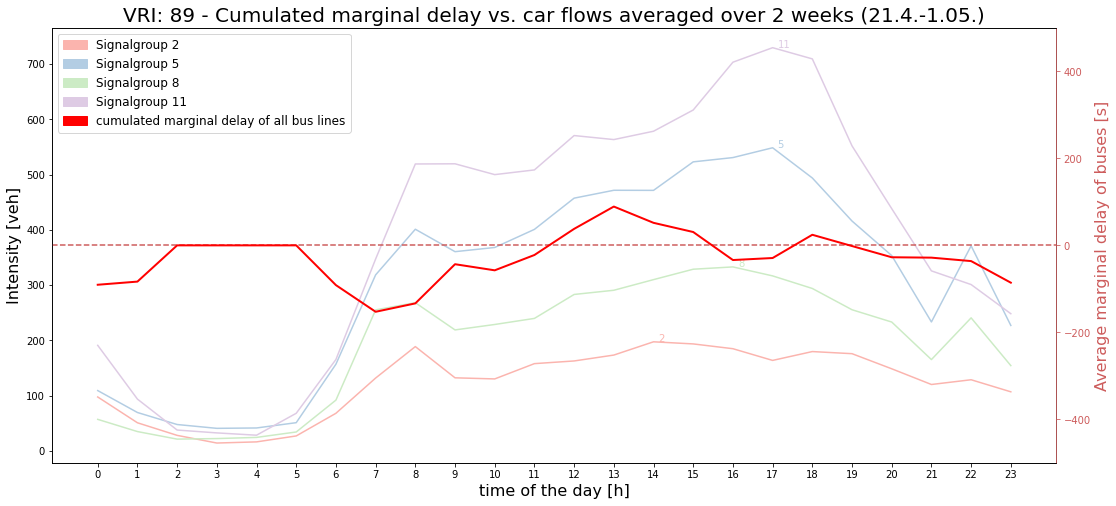

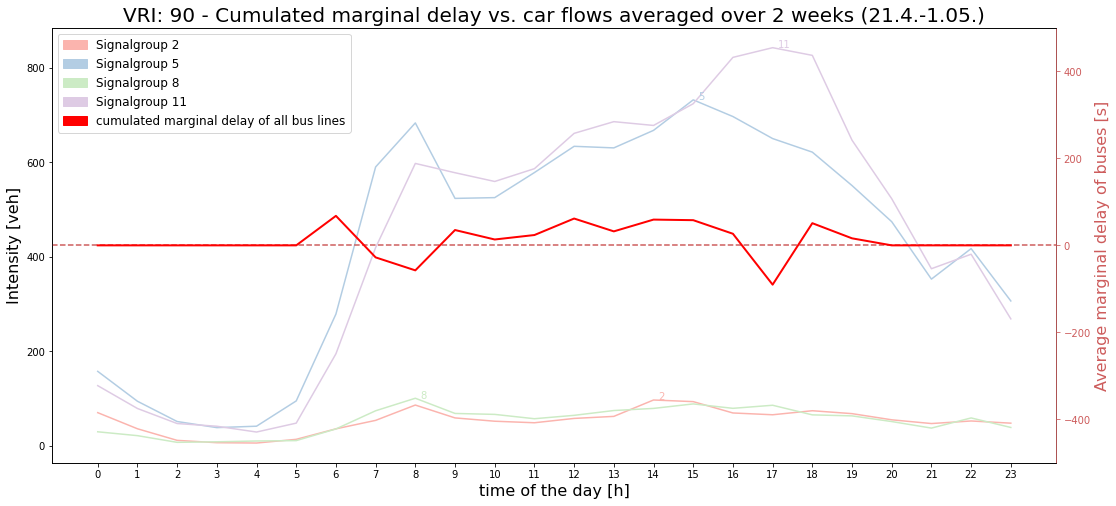

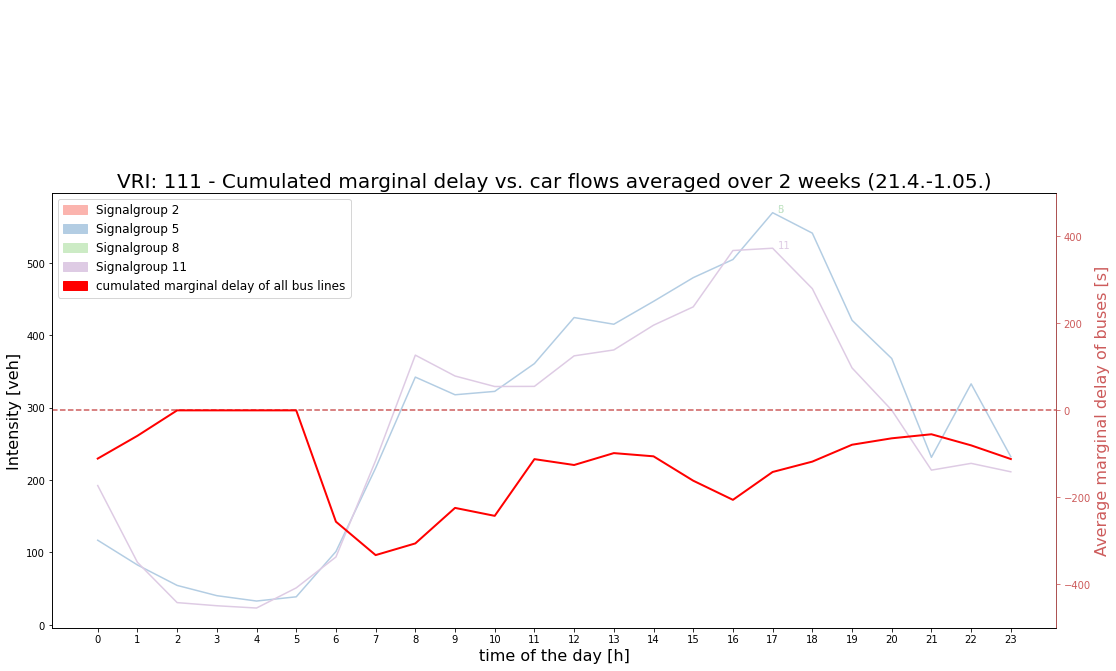

In [15]:
# average car flow - PT delay total
for p,vri in enumerate(vris):
    #figure settings
    fig =plt.figure(figsize=(18,8))
    ax= plt.subplot(111)
    ax.set_xlabel('time of the day [h]', fontsize = 16)
    ax.set_ylabel('Intensity [veh]', fontsize = 16)
    ax.set_title('VRI: {} - Cumulated marginal delay vs. car flows averaged over 2 weeks (21.4.-1.05.)'.format(vri), fontsize = 20)
    
    #Car
    #average over two weeks. group by time of the day, flows are from 21.4.-29.4 without weekdays and holidays
    for sg in [2,5,8,11]:
      #manipulation to include left turns df1 and df2:
      df1 = car_h[vri].loc[(car_h[vri].Signaalgroep == sg)]
      df2 = car_h[vri].loc[(car_h[vri].Signaalgroep == sg+1)]
      #average is taken per hour of the day
      df1 = df1.groupby('Uur').mean()
      df2 = df2.groupby('Uur').mean()
      #add flow of leftturns
      if not df2.empty:
          df1 = df1.align(df2)[0]
          df2 = df1.align(df2)[1]
          intensity = df1['Intensiteit'].values + df2['Intensiteit'].values
          time = df1.index.values
          ax.plot(time, intensity, color = c_roads[vri][sg], label = sg)
      elif not df1.empty:
          intensity = df1['Intensiteit'].values
          time = df1.index.values
          ax.plot(time, intensity, color = c_roads[vri][sg], label = sg )
      else:
        pass
      ax.annotate(sg, (np.argmax(intensity), np.max(intensity)), textcoords = "offset points", xytext=(5,0), ha='left', color = c_roads[vri][sg])

    #PT
    ax2= ax.twinx()
    ax2.spines['right'].set_color('indianred')
    ax2.tick_params(axis='y', colors='indianred')
    ax2.set_ylabel('Average marginal delay of buses [s]', color = 'indianred', fontsize = 16)
    ax2.set_ylim([-500, 500])    
    #plot zero line
    ax2.axhline(y=0, color='indianred', linestyle = '--')   
    bus_delay_cum = {t:0 for t in range(24)}
    for line in buslines:
      for d in range(2):
        #average over 2 weeks (21.4.-29.4)
        #aggregate per hour
        bus=bus_agg_compl[vri][line][d].reset_index(drop = False)
        if not bus.empty:
          bus['hour'] = [x.hour for x in bus.time]
          bus_avg_h = bus.groupby('hour').mean()
          #sum over buslines
          for t_bus in bus_avg_h.index:
              bus_delay_cum [t_bus] += bus_avg_h.marg_delay['mean'][bus_avg_h.index == t_bus].iloc[0]
    ax2.plot(list(bus_delay_cum.keys()), list(bus_delay_cum.values()), c='red', linewidth = 2)
    plt.legend(handles= [legend2, legend5, legend8, legend11, legendbus], loc = 'upper left', fontsize= 12)
    ax.set_xticks(np.arange(0, 24, step=1))
    #save figure
    fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/Flows/carflows_pt_MARG_delay_2weeks_{}.pdf'.format(vri))  

Remark: Bus Number 01 is traveling on 't Goylaan (approaches 5 and 11) and on approach 2. 

The values of the marginal delay are mostly negative, which means that the buses catch up delay when crossing the intersection. They are less delayed at the next busstop then before.

Therefore the graph makes sense that for the movement from south (approach 2) to west (crossing approach 5 and 11) has a higher marginal delay when there is a lot of traffic on the main corridor (5-11). In the other direction the bus doesn't get much influenced, it is just exposed to the general traffic conditions. 


## Plot of queue length + delay of buses
1. Data is over two weeks, take the average over workdays to avoid irregularities
2. Punctuality of buslines: 
  - consider marginal delay over intersection: which is the difference in delay from a bus stop before the intersection and at a busstop after the intersection \\
  ⟶ advantage: ignore what happened elsewhere in the network
  - consider initial delay: which is the delay at a busstop before the intersection \\
  ⟶ initial delay might have an effect on the behavior of the bus when it approaches the intersection (TSP call)

In [18]:
#averaging data over two weeks
#------------------------------
#queue length
#data is transformed by the seaborn.boxplot automatically, no need to average it

#status INM system
status_INM_avg = {v: [] for v in vris}
for vri in vris: 
  df = status_INM[vri]
  df['hour'] = [x.hour for x in df.index]
  df= df.groupby('hour').agg({'status_on': 'mean'})
  df['status_on_avg'] = df.status_on > 0.2
  status_INM_avg[vri] = df
#PT
bus_avg_day = {v: {l: {d: pd.DataFrame() for d in range(2)}for l in buslines} for v in vris}
for vri in vris: 
  for line in buslines: 
    for d in range(2):
      df = bus_agg_compl[vri][line][d]
      if not df.empty:
        df['hour'] = [x.hour for x in df.index]
        df= df.groupby('hour').agg(marg_delay_mean = pd.NamedAgg(column = ('marg_delay', 'mean'), aggfunc = 'mean'), marg_delay_std = pd.NamedAgg(column = ('marg_delay', 'mean'), aggfunc = 'std' ))
        bus_avg_day[vri][line][d] = df


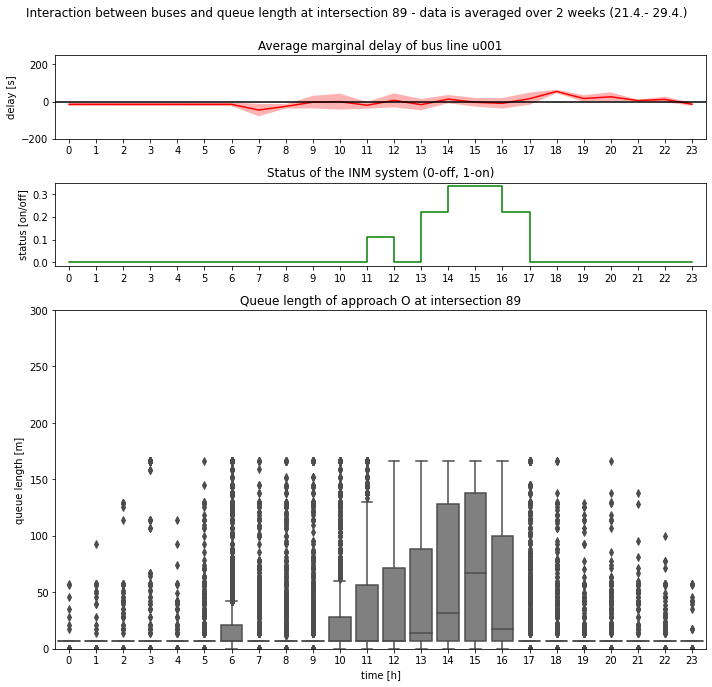

In [19]:
#Queue length + PT 
#-----------------

############ PARAMATERS ##############
# queue length data: each road section is called after the intersection with North, East, South, and West (N,O,Z,W)
#intersection of interest
vri= 89
vri_txt = '089' #090 and 111
#direction of interest
d = 'O'  #directions = ['N', 'O', 'Z', 'W']
#busline of interest
line = 'u001'
#first (0) or second(1) pair of busstops from the initial definition
stops = 0
######################################

#queue length
#df of direction at intersection vri
df_d = queuelength[vri][d]
#add column with hour to df
df_d['time_h'] = [t.hour for t in df_d.index]
#display(df_d.head())

#plot of PT delay
fig = plt.figure(figsize=(10,10))
ax.grid(visible = None, which = 'both')
#gs = gridspec.GridSpec(4, 2, width_ratios=[2.5, 1])
ax = plt.subplot(511)
ax.set_ylabel('delay [s]')
ax.set_ylim([-200, 250])
mean_delay = bus_avg_day[vri][line][stops]['marg_delay_mean'].values
std_delay = bus_avg_day[vri][line][stops]['marg_delay_std'].values
t_delay = bus_avg_day[vri][line][stops].index
ax.plot(t_delay, mean_delay, c = 'r')
ax.fill_between(t_delay, mean_delay+std_delay, mean_delay-std_delay, alpha=0.3, facecolor= 'r')
ax.set_title('Average marginal delay of bus line {}'.format(line))
ax.axhline(y=0, color='k')

#Status of INM system is active or not
ax2 = plt.subplot(512, sharex = ax)
ax2.step(status_INM_avg[vri].index, status_INM_avg[vri].status_on, where = 'post', c = 'g')
ax2.set(ylabel ='status [on/off]')
ax2.set_title('Status of the INM system (0-off, 1-on)')

#Queuelength in form ofboxplot with seaborn
ax3 = plt.subplot(5, 1, (3,5), sharex = ax)
ax3 = seaborn.boxplot(x=df_d.time_h, y=df_d.buffervulling_m, color='grey')
ax3.set_ylim([0, 300])
ax3.set(xlabel="time [h]", ylabel="queue length [m]")
ax3.set_title('Queue length of approach {} at intersection {}'.format(d, vri))

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.suptitle('Interaction between buses and queue length at intersection {} - data is averaged over 2 weeks (21.4.- 29.4.)'.format(vri), verticalalignment = 'top')
#save fig
fig.savefig('/content/gdrive/MyDrive/Colab Notebooks/PDM/Saved plots/PT&Queuelength/PT_queuelength_vri{}_{}_bus_{}_{}'.format(vri,d,line,stops))  


Remark:

_Average marginal delay_: The average is taken over 1 hour. If the marginal delay is neagtive, the bus reduces his delay while crossing that intersection. If it is positive, it means that the delay is further increased. 

_Status of GNV system_: The data is averaged over 1 hour. The system is considered to be switched on if it was working at least 30 % of the time during that hour. The GNV system is switched on during the morning rush hour (8h morning) and from the afternoon again. The times it is used correlates with the time when an increased queue length can be observed.

_Queue length_: The queue length observation show some variation during the day. The boxplot allows us to see where the major trend of the measures leads. A morning rush hour as well as an evening rush hour starting in the early afternoon are observable.

_Correlation Bus - Queue length_: With the morning rush hour the delay of buses is increased. In the afternoon the buses tend to reduce their delay even though the queues in the streets stay important. 